# COGS 108 - Final Project: 
# The Real Crime: Driving Too Fast or Judging Too Quickly?

#### Team Members:

Andy Xia A12947881

Charlie Tamer A10738406

Jodi Lam A91081797

Marie Schneider A11727873

Vishal Bobba A12226838

# Introduction and Background:

#### Research Question:

Does race correlate with either proportion of traffic stops or the outcome of the stops (warning, citation, arrest, etc.)? 

#### Hypothesis:

We predict that people of color are more likely to be stopped by the police than white people within the same region. Furthermore, we believe black, Hispanic, other, and Asian people will be disproportionately stopped by the police in that order.  We suspect race will have a correlation with the result of stop, with people of color disproportionately receiving harsher punishment than white people. 

#### Background:

Police brutality and racism have been two huge social concerns in the last couple of years within the United States. For example, Black Lives Matter, a racial justice movement, was spurred by the shooting of Mike Brown, a black teenager, by a white police officer. Since then, there have not only been countless shootings but only other instances of racism within police departments. In a 2016 study it was found that while black people comprise only 13% of the United States population, they account for 28% of the arrests made [1]. With statistics such as these and increased news coverage a lot of research has been done within this area.

There has been research correlating race with both the amount of traffic stops and the outcome of the stop. Waller County, Texas was recently put under the spotlight due to the mysterious death of Sandra Bland, a black woman who was taken into custody as a result of a traffic stop. According to Census estimates, Waller County is 70.5% white, 25.8% black, 1.5% Native American, and .7% Asian. Yet those who are stopped for traffic violations are only 44.3% white, 29.1% black, and 24.8% Hispanic [2]. Similar to this situation, within San Francisco it is reported that once pulled over for a traffic violation, black drivers are more than four times and Latinos more than two and a half times likely to be searched compared to white drivers [3].

This information led us to form our hypothesis. In order for police brutality and racism to stop, questions such as ours must be answered. Doing data analysis such as ours not only brings light to the racism within police departments, but also gives concrete numbers and answers. With concrete data and answers it is hard to deny for both the police and the public that racism within our country is still not an issue today.

#### References:

1) http://www.nbcnews.com/health/health-news/black-people-more-likely-be-stopped-cops-study-finds-n616546 

2) http://www.motherjones.com/politics/2015/07/traffic-stops-black-people-waller-county 

3) http://www.sfchronicle.com/crime/article/Racial-disparities-in-SF-traffic-searches-raise-7235690.php

# Data Description:

Dataset Name: Traffic Stops by Race and Ethnicity in San Francisco (2016)
- Link to the dataset: http://sanfranciscopolice.org/sites/default/files/Documents/PoliceDocuments/Statistics/sfpd-all-traffic-stop-2016%281%29.xlsx
- Number of observations: 97,013 totaled across three documents. This dataset is the combination of three documents. Document “2016” has 65,535 observations, “Crossroads 2016” has 25,805 observations, and “eStops 2016” has 4,855 observations. “2016” and “Crossroads 2017 each have ten features: date, time, race, sex, age, reason for stop, rest, result of stop, location for stop, and district. “eStops 2016” also has the same ten features with an extra feature for the location of the stop. 
-Data Cleaning: Since we are using multiple datasets that cover similar information, specifically those datasets that deal with traffic stops, we will need to make sure that data entered under similar fields (i.e. date, race, or reason for stop) are coded in the same way across datasets in order to properly merge the data into one unified set without creating duplicates (e.g. by fixing discrepancies such as “crash” vs. “collision”). Due to the large amount of data we are working with, it is possible we may miss some differences in wording by simply searching through the data manually, so we will look for a sort of legend that may be provided through the same source as the datasets that might delineate all the terms used in the dataset.

Dataset Name: ACS DEMOGRAPHIC AND HOUSING ESTIMATES 2011-2015 American Community Survey 5-Year Estimates
- Link to the dataset: https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=CF
- Number of observations: 152. A dataset composed of 152 figures depicting the populations of various demographics of San Francisco, including: age, race, and gender. 
-Data Cleaning: As this data set is much smaller, all we will need to do is drop any unneeded columns and rows. Then rename rows and columns accordingly. 

# Data Cleaning / Pre-Processing:

In [38]:
# Imports
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind
#import datetime #probably not necessary; see

In [39]:
# Load datasets


# SF Police Department (PD) demographics
df_PD = pd.read_csv( open( '../PR_060/SFPDdemographics2017.csv' ) )

# NEW SF Population Demographics
df_SF = pd.read_csv( open( '../PR_060/ACS_15_5YR_DP05.csv' ) )

# SF Traffic Stops (TS) 
#   had to split excel file sheets into separate csv files and add a
#   different " encoding = '' " argument to make it read without 
#   throwing errors)
df_TS1 = pd.read_csv(
    open(
        '../PR_060/SFtrafficstops2016_1.csv',
        encoding = 'latin-1'
    )
)

df_TS2 = pd.read_csv( open( '../PR_060/SFtrafficstops2016_2.csv' ) )

### Part 1: SF Population Demographics

In [40]:
# load NEW SF Population Demographics
df_SF = pd.read_csv(open( '../PR_060/ACS_15_5YR_DP05.csv'))

# Selecting the relevent columns and rows and droping unnessicay rows
df_SF = df_SF[['DP05: ACS DEMOGRAPHIC AND HOUSING ESTIMATES' , 'Unnamed: 3', 'Unnamed: 7']][84:98]
df_SF = df_SF.drop(df_SF.index[[2, 3, 4, 5, 6]])

#reset index numbering
df_SF.reset_index(drop = True , inplace = True)

# Rename columns
df_SF.rename(columns=
             {"DP05: ACS DEMOGRAPHIC AND HOUSING ESTIMATES": "Race", 
              "Unnamed: 3": "Total", "Unnamed: 7": "%" }, inplace = True)

#Remove the commas and %s within the data
df_SF["Total"] = df_SF["Total"].str.replace(",", "")
df_SF["%"] = df_SF["%"].str.replace(",", "")
df_SF["%"] = df_SF["%"].str.replace("%", "")

#Creating the "Other" Category
other_count = 0

#saving total varible (if needed later)
total_race = int(df_SF['Total'][0])

#Counts all people from races not included within our traffic reports
#inclues: American Indian and Alaska Native, American Indian and Alaska Native, 
#Native Hawaiian and Other Pacific Islander, Some other race, Two or more races 
for i in range( 0 , len(df_SF)):
    #if the the value within the total column is less than our lowest reported demographic
    if (int(df_SF['Total'][i]) < int(df_SF['Total'][3])): 
        other_count = other_count + int(df_SF['Total'][i])
        df_SF['Total'][i] = None 

#Drops rows in which the race is not included within our traffic reports
df_SF = df_SF.dropna(axis = 0, how = 'any')

#Drops Total
df_SF = df_SF.drop(df_SF.index[[0]])

#reset index numbering
df_SF.reset_index(drop = True , inplace = True)

#renaming
df_SF['Race'][0] = 'Hispanic'
df_SF['Race'][1] = 'White'
df_SF['Race'][2] = 'Black'
df_SF['Race'][3] = 'Asian'

#finding the percent value
percent = (other_count/total_race)*100

#Appending the 'other' row
df_other = {'Race' : 'Other', 'Total': other_count, '%': percent}
df_SF = df_SF.append(df_other, ignore_index=True)

#drop % column to more easily compare data later
df_SF = df_SF.drop('%', 1)

#saving population by race
total_hispanic = int(df_SF['Total'][0])
total_white = int(df_SF['Total'][1])
total_black = int(df_SF['Total'][2])
total_asian = int(df_SF['Total'][3])
total_other = int(df_SF['Total'][4])

df_SF

#saving population by race
#total_hispanic = df_SF.get(df_SF['Race'][0])

,Race,Total
0,Hispanic,128619
1,White,346732
2,Black,44879
3,Asian,281896
4,Other,38637


### Part 2: SF Traffic Stops Data


In [41]:
# load and clean df_TS1 (Traffic Stop data 1) according to above criteria

#load into dataframe
df_TS1 = pd.read_csv(
    open(
        '../PR_060/SFtrafficstops2016_1.csv',
        encoding = 'latin-1'
    )
)

#drop NaN values 
df_TS1.dropna( inplace = True )

# convert df_TS1['Date of Stop '] values to datetime
#df_TS1['Date of Stop '] = pd.to_datetime(df_TS1["Date of Stop "] , format = '%d-%b-%y')

# cut out everything but Race, ResultsOfSearch, & ResultOfStop (unless we need the other stuff)
df_TS1 = df_TS1[['Race' , 'ResultsOfSearch' , 'ResultOfStop']]

# Replace Race Codes with full Race str
# **need to determine if Filipino fell under Asian or Pacific Isander in 2016 census
df_TS1['Race'] = df_TS1.Race.replace( 
    [ 'W' , 'B' , 'A' , 'H' , 'O' ], # to be replaced
    [ 'White' , 'Black' , 'Asian' , "Hispanic" , 'Other' ] # replace with
)

# Replace ResultsOfSearch Codes with full strings
df_TS1['ResultsOfSearch'] = df_TS1.ResultsOfSearch.replace(
    to_replace =     #to be replaced
    [0, 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9],
    value =     #replace with
    ['Probation/Parole Search',
     'No Search',
     'Search Without Consent, Positive Result',
     'Search Without Consent, Negative Result',
     'Search With Consent, Positive Result',
     'Search With Consent, Negative Result',
     'Search Incidental To Arrest, Positive Result',
     'Search Incidental To Arrest, Negative Result',
     'Vehicle Inventory, Positive Result',
     'Vehicle Inventory, Negative Result']
)

# Replace ResultOfStop codes with full strings
df_TS1['ResultOfStop'] = df_TS1.ResultOfStop.replace(
    to_replace =     #to be replaced
    [1 , 2 , 3 , 4 , 5],
    value =     #replace with
    ['Arrest',
     'Citation',
     'Warning',
     'Incident Report',
     'No Further Action']
)

#check how many unique values exist to make sure we don't miss any
##df_TS1['Race'].unique() #replace 'Race' with any column name

df_TS1

,Race,ResultsOfSearch,ResultOfStop
0,White,No Search,Citation
1,Asian,No Search,Citation
2,Black,No Search,Warning
3,Black,No Search,Citation
4,Hispanic,No Search,Warning
5,White,Probation/Parole Search,Warning
6,Other,No Search,Warning
7,White,No Search,Citation
8,Other,No Search,Citation
9,White,No Search,Citation


In [42]:
# load and clean df_TS2 (Traffic Stop data part 2) according to above criteria

# load into dataframe
df_TS2 = pd.read_csv( open( '../PR_060/SFtrafficstops2016_2.csv' ) )

# cut out everything but Race, ResultsOfSearch, & ResultOfStop
df_TS2 = df_TS2[['Race' , 'ResultsOfSearch' , 'ResultOfStop']]

#drop NaN values 
df_TS2.dropna( inplace = True )

#replace Race values for consistency
df_TS2 = df_TS2.replace( 
    ['W WHITE', 'B BLACK', 'A ASIAN', 'H HISPANIC', 'O ALL OTHERS'], # to be replaced
    [ 'White' , 'Black' , 'Asian' , "Hispanic" , 'Other' ] # replace with
)

# Replace ResultsOfSearch Codes for consistency
df_TS2['ResultsOfSearch'] = df_TS2.ResultsOfSearch.replace(
    to_replace =     #to be replaced
    ['0 Searched as a Result of Probation or Parole Condition',
     '1 No Search',
     '2 Search Without Consent, Positive Result',
     '3 Search Without Consent, Negative Result',
     '4 Search With Consent, Positive Result',
     '5 Search With Consent, Negative Result',
     '6 Search Incidental To Arrest, Positive Result',
     '7 Search Incidental To Arrest, Negative Result',
     '8 Vehicle Inventory, Positive Result',
     '9 Vehicle Inventory, Negative Result'],
    value =     #replace with
    ['Probation/Parole Search', 
     'No Search',
     'Search Without Consent, Positive Result',
     'Search Without Consent, Negative Result',
     'Search With Consent, Positive Result',
     'Search With Consent, Negative Result',
     'Search Incidental To Arrest, Positive Result',
     'Search Incidental To Arrest, Negative Result',
     'Vehicle Inventory, Positive Result',
     'Vehicle Inventory, Negative Result']
)

# Replace ResultOfStop codes for consistency
df_TS2['ResultOfStop'] = df_TS2.ResultOfStop.replace(
    to_replace =     #to be replaced
    ['1 In Custody Arrest',
     '2 Citation',
     '3 Warning',
     '4 Incident Report',
     '5 No Further Action'],
    value =     #replace with
    ['Arrest',
     'Citation',
     'Warning',
     'Incident Report',
     'No Further Action']
)

#check how many unique values exist to make sure we don't miss any
##df_TS2['Race'].unique() #replace 'Race' with any column name

df_TS2

,Race,ResultsOfSearch,ResultOfStop
0,Other,No Search,Citation
1,Other,No Search,Citation
2,Other,No Search,Citation
3,Other,No Search,Citation
4,Black,No Search,Citation
5,Other,No Search,Citation
6,Other,No Search,Citation
7,Black,No Search,Citation
8,White,No Search,Citation
9,Other,No Search,Citation


In [43]:
# combine df_TS1 and df_TS2

df_TS = df_TS1.append(
    df_TS2, #append df_TS2 rows to end of df_TS1
    ignore_index = True #don't keep original df_TS2 row indices; continue sequentially instead
)

df_TS

,Race,ResultsOfSearch,ResultOfStop
0,White,No Search,Citation
1,Asian,No Search,Citation
2,Black,No Search,Warning
3,Black,No Search,Citation
4,Hispanic,No Search,Warning
5,White,Probation/Parole Search,Warning
6,Other,No Search,Warning
7,White,No Search,Citation
8,Other,No Search,Citation
9,White,No Search,Citation


# Data Visualization / Testing Assumptions:

Chi-squared Goodness of Fit Test

Assumptions: 

1. categorical variable

2. independent observations

3. large enough expected frequencies


In [44]:
# Saving the amount of traffic stops based on race 

df_race = df_TS['Race'].value_counts()
white = df_race['White']
black = df_race['Black']
asian = df_race['Asian']
hispanic = df_race['Hispanic']
other = df_race['Other']

#creates a dataframe listing the amount of stops based on race

data = {'Traffic_Stops' : [white,black,asian,hispanic, other]}

df_racestops = pd.DataFrame(data=data,index=['white','black','asian','hispanic', 'other'])
df_racestops

,Traffic_Stops
white,38043
black,15759
asian,17638
hispanic,15231
other,17170


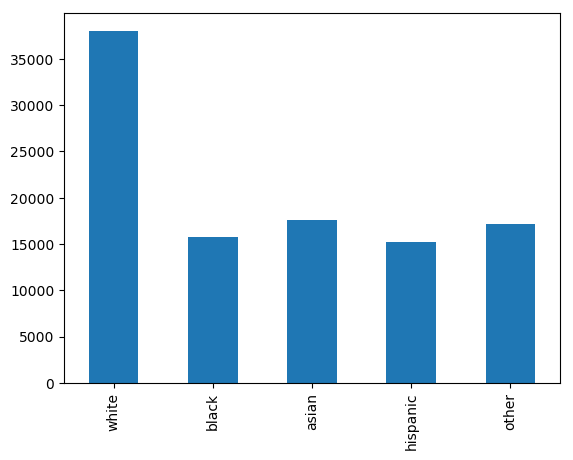

In [45]:
#Visualizing the amount of traffic stops based on race

df_race = (df_racestops['Traffic_Stops']).plot.bar()
f1 = plt.gcf()
plt.show()

In [46]:
# Saving values for counts of 'ResultOfStop' 

df_result = df_TS['ResultOfStop'].value_counts()
arrest = df_result['Arrest']
citation = df_result['Citation']
warning = df_result['Warning']
incidentreport = df_result['Incident Report']
nofurtheraction = df_result['No Further Action']

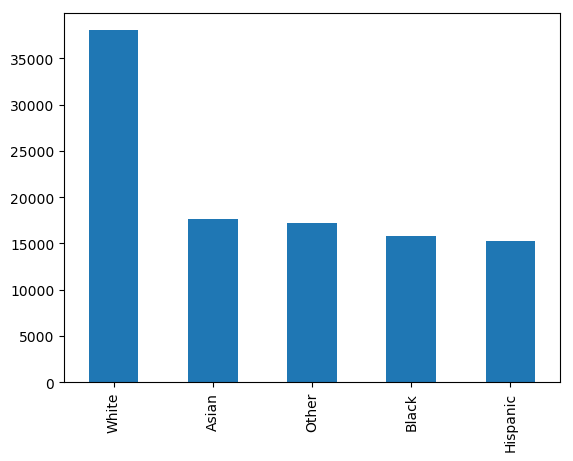

In [47]:
# Bar plot for the 'Race' data
df_race = (df_TS['Race'].value_counts()).plot.bar()
f2 = plt.gcf()
plt.show()

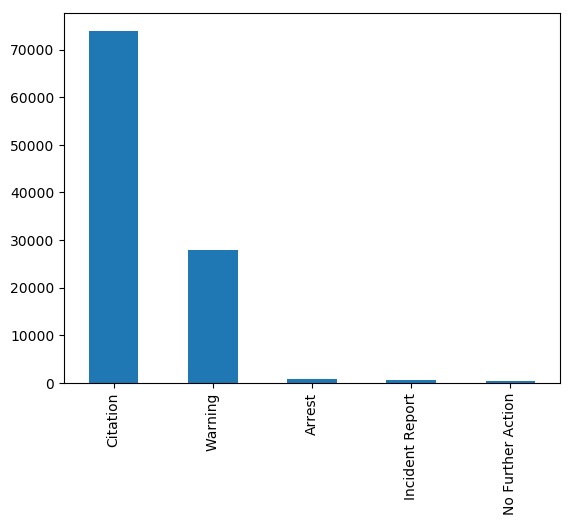

In [48]:
# Bar plot for the 'ResultOfStop' data
df_resultOfStop = (df_TS['ResultOfStop'].value_counts()).plot.bar()
f3 = plt.gcf()
plt.show()

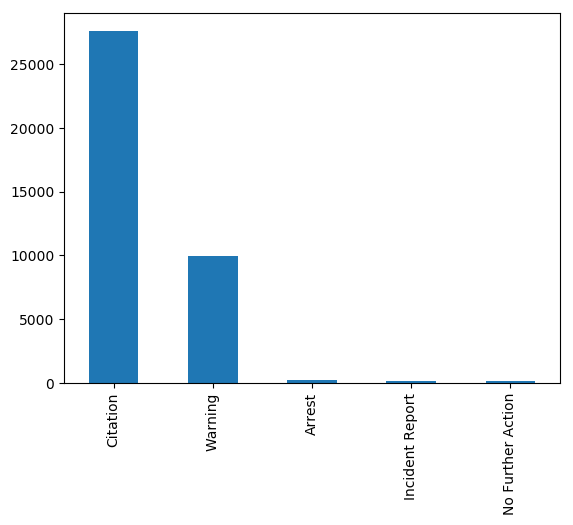

In [49]:
# Bar plot of the 'ResultOfStop' data for those whose race is 'White'

result_white = df_TS.loc[df_TS['Race'] == 'White']
(result_white['ResultOfStop'].value_counts()).plot.bar()

f4 = plt.gcf()
plt.show()

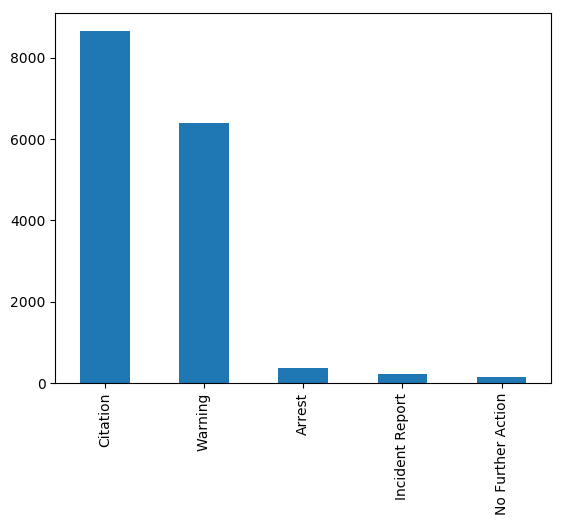

In [50]:
# Bar plot of the 'ResultOfStop' data for those whose race is 'Black'

result_black = df_TS.loc[df_TS['Race'] == 'Black']
(result_black['ResultOfStop'].value_counts()).plot.bar()

f5 = plt.gcf()
plt.show()

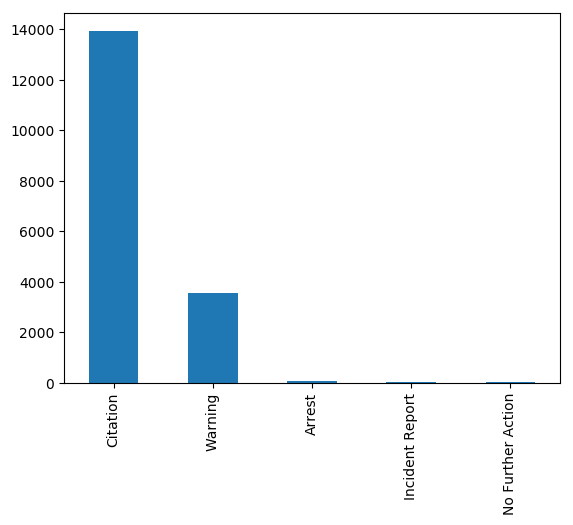

In [51]:
# Bar plot of the 'ResultOfStop' data for those whose race is 'Asian'

result_asian = df_TS.loc[df_TS['Race'] == 'Asian']
(result_asian['ResultOfStop'].value_counts()).plot.bar()

f6 = plt.gcf()
plt.show()

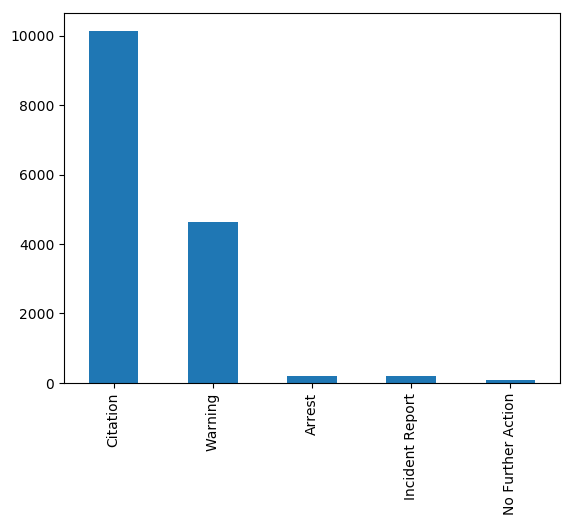

In [52]:
# Bar plot of the 'ResultOfStop' data for those whose race is 'Hispanic'

result_hispanic = df_TS.loc[df_TS['Race'] == 'Hispanic']
(result_hispanic['ResultOfStop'].value_counts()).plot.bar()

f7 = plt.gcf()
plt.show()

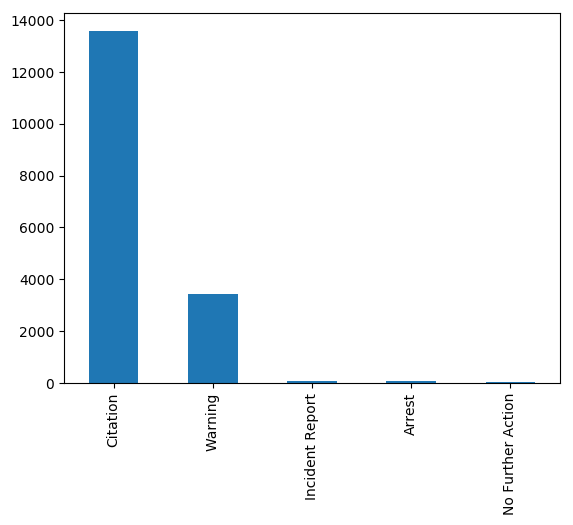

In [53]:
# Bar plot of the 'ResultOfStop' data for those whose race is 'Other'

result_other = df_TS.loc[df_TS['Race'] == 'Other']
(result_other['ResultOfStop'].value_counts()).plot.bar()

f8 = plt.gcf()
plt.show()

# Data Analysis and Results:

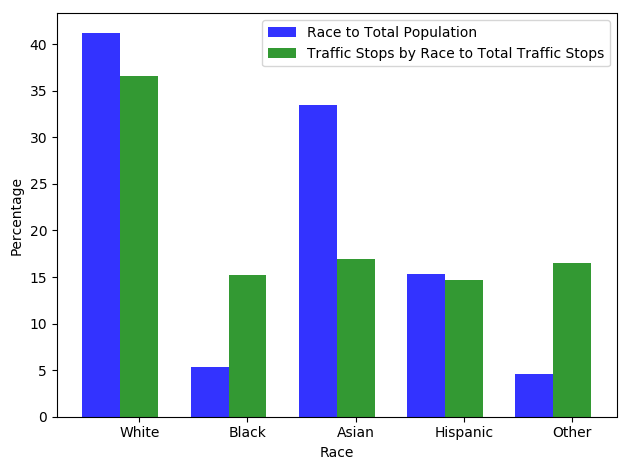

In [54]:
# Bar graph showing ratio of race to total population and ratio of traffic stops to race

#total number of traffic stops 
df_totalrace = 0
for i in range(0 , len(df_racestops)): 
    df_totalrace = df_racestops['Traffic_Stops'][i]+ df_totalrace
    
#percentages of race to total population
per_white = (total_white/total_race)*100
per_asian = (total_asian/total_race)*100
per_hispanic = (total_hispanic/total_race)*100
per_black = (total_black/total_race)*100
per_other = (total_other/total_race)*100

#percentage of traffic stops by race to ratio of race to total population
cit_per_white = (white/df_totalrace)*100
cit_per_asian = (asian/df_totalrace)*100
cit_per_hispanic = (hispanic/df_totalrace)*100
cit_per_black = (black/df_totalrace)*100
cit_per_other = (other/df_totalrace)*100

#setting up bar graph
n_groups = 5
race_pop = (per_white, per_black, per_asian, per_hispanic, per_other)
race_cit = (cit_per_white, cit_per_black, cit_per_asian, 
            cit_per_hispanic, cit_per_other)

fig, ax = plt.subplots()
index = np.arange(n_groups)

bar_width = .35
opacity = .8

rects1 = plt.bar(index, race_pop, bar_width, alpha = opacity, color = 'b', 
                 label = 'Race to Total Population')

rects2 = plt.bar(index + bar_width, race_cit, bar_width, alpha = opacity,
                 color = 'g', label = 'Traffic Stops by Race to Total Traffic Stops')

plt.xlabel('Race')
plt.ylabel('Percentage')
plt.xticks(index + bar_width, ('White', 'Black', 'Asian', 'Hispanic', 'Other'))
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
#editing data to be comapred for Chi Squared Goodness of Fit Test for rate of stop

#reordering df_racestops to more easily compare data
df_racestops = df_racestops.reindex(["hispanic", "white", "black", "asian", "other"])

#setting index of df_SF to more easily compare data 
df_SF.set_index('Race', inplace=True)

#printing out data to compare
print(df_SF)
print(df_racestops)


           Total
Race            
Hispanic  128619
White     346732
Black      44879
Asian     281896
Other      38637
          Traffic_Stops
hispanic          15231
white             38043
black             15759
asian             17638
other             17170


In [56]:
#Chi Squared Goodness of Fit Test for the number of stops based on race

#df_SF total
df_total = 0
for i in range(0 , len(df_SF)): 
    df_total = int(df_SF['Total'][i])+ df_total
    
#df_racestops total
df_totalrace = 0
for i in range(0 , len(df_racestops)): 
    df_totalrace = df_racestops['Traffic_Stops'][i]+ df_totalrace

chi_squared_stat = 0
for i in range(0 , len(df_SF)):
    
    #ratio of df_SF
    sf_ratio = (int(df_SF['Total'][i])/df_total)*100
    #ratio of df_racestops
    race_ratio = ((df_racestops['Traffic_Stops'][i])/df_totalrace)*100
    chi_squared_stat = ((race_ratio - sf_ratio)**2/race_ratio) + chi_squared_stat
print(chi_squared_stat)


31.7166762911


In [57]:
#checking to see if our value is significant

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 4)   # Df = number of variable categories - 1

print("Critical value:")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=4)
print("P-value:")
print(p_value)

Critical value:
9.48772903678
P-value:
2.18587846723e-06


In [58]:
#Finding the amount of results of the stop for white 

#amount
amount_white = df_racestops["Traffic_Stops"][1]

#number of arrests for those who are white
result_white.reset_index(drop = True , inplace = True)
arrest_white = 0
for i in range(0 , len(result_white)):
    if (result_white['ResultOfStop'][i] == "Arrest"):
        arrest_white += 1

#number of citations for those who are white
citation_white = 0
for i in range(0 , len(result_white)):
    if (result_white['ResultOfStop'][i] == "Citation"):
        citation_white += 1

#number of warningss for those who are white
warning_white = 0
for i in range(0 , len(result_white)):
    if (result_white['ResultOfStop'][i] == "Warning"):
        warning_white += 1

#number of incident reports for those who are white
incident_white = 0
for i in range(0 , len(result_white)):
    if (result_white['ResultOfStop'][i] == "Incident Report"):
        incident_white += 1
        
#number of no further action for those who are white
action_white = 0
for i in range(0 , len(result_white)):
    if (result_white['ResultOfStop'][i] == "No Further Action"):
        action_white += 1

In [59]:
#Finding the amount of results of the stop for black 

#amount
amount_black = df_racestops["Traffic_Stops"][2]

#number of arrests for those who are black
result_black.reset_index(drop = True , inplace = True)
arrest_black = 0
for i in range(0 , len(result_black)):
    if (result_black['ResultOfStop'][i] == "Arrest"):
        arrest_black += 1

#number of citations for those who are black
citation_black = 0
for i in range(0 , len(result_black)):
    if (result_black['ResultOfStop'][i] == "Citation"):
        citation_black += 1

#number of warningss for those who are black
warning_black = 0
for i in range(0 , len(result_black)):
    if (result_black['ResultOfStop'][i] == "Warning"):
        warning_black += 1

#number of incident reports for those who are black
incident_black = 0
for i in range(0 , len(result_black)):
    if (result_black['ResultOfStop'][i] == "Incident Report"):
        incident_black += 1
        
#number of no further action for those who are black
action_black = 0
for i in range(0 , len(result_black)):
    if (result_black['ResultOfStop'][i] == "No Further Action"):
        action_black += 1


In [60]:
#Finding the amount of results of the stop for asian 

#amount
amount_asian = df_racestops["Traffic_Stops"][3]

#number of arrests for those who are asian
result_asian.reset_index(drop = True , inplace = True)
arrest_asian = 0
for i in range(0 , len(result_asian)):
    if (result_asian['ResultOfStop'][i] == "Arrest"):
        arrest_asian += 1

#number of citations for those who are asian
citation_asian = 0
for i in range(0 , len(result_asian)):
    if (result_asian['ResultOfStop'][i] == "Citation"):
        citation_asian += 1

#number of warningss for those who are asian
warning_asian = 0
for i in range(0 , len(result_asian)):
    if (result_asian['ResultOfStop'][i] == "Warning"):
        warning_asian += 1

#number of incident reports for those who are asian
incident_asian = 0
for i in range(0 , len(result_asian)):
    if (result_asian['ResultOfStop'][i] == "Incident Report"):
        incident_asian += 1
        
#number of no further action for those who are asian
action_asian = 0
for i in range(0 , len(result_asian)):
    if (result_asian['ResultOfStop'][i] == "No Further Action"):
        action_asian += 1
        

In [61]:
#Finding the amount of results of the stop for hispanic 

#amount
amount_hispanic = df_racestops["Traffic_Stops"][0]

#number of arrests for those who are hispanic 
result_hispanic.reset_index(drop = True , inplace = True)
arrest_hispanic = 0
for i in range(0 , len(result_hispanic)):
    if (result_hispanic['ResultOfStop'][i] == "Arrest"):
        arrest_hispanic += 1

#number of citations for those who are hispanic
citation_hispanic = 0
for i in range(0 , len(result_hispanic)):
    if (result_hispanic['ResultOfStop'][i] == "Citation"):
        citation_hispanic += 1

#number of warningss for those who are hispanic
warning_hispanic = 0
for i in range(0 , len(result_hispanic)):
    if (result_hispanic['ResultOfStop'][i] == "Warning"):
        warning_hispanic += 1

#number of incident reports for those who are hispanic
incident_hispanic = 0
for i in range(0 , len(result_hispanic)):
    if (result_hispanic['ResultOfStop'][i] == "Incident Report"):
        incident_hispanic += 1
        
#number of no further action for those who are hispanic
action_hispanic = 0
for i in range(0 , len(result_hispanic)):
    if (result_hispanic['ResultOfStop'][i] == "No Further Action"):
        action_hispanic += 1


In [62]:
#Finding the amount of results of the stop for other 

#amount
amount_other = df_racestops["Traffic_Stops"][4]

#number of arrests for those who are other 
result_other.reset_index(drop = True , inplace = True)
arrest_other = 0
for i in range(0 , len(result_other)):
    if (result_other['ResultOfStop'][i] == "Arrest"):
        arrest_other += 1

#number of citations for those who are other
citation_other = 0
for i in range(0 , len(result_other)):
    if (result_other['ResultOfStop'][i] == "Citation"):
        citation_other += 1

#number of warningss for those who are other
warning_other = 0
for i in range(0 , len(result_other)):
    if (result_other['ResultOfStop'][i] == "Warning"):
        warning_other += 1

#number of incident reports for those who are other
incident_other = 0
for i in range(0 , len(result_other)):
    if (result_other['ResultOfStop'][i] == "Incident Report"):
        incident_other += 1
        
#number of no further action for those who are other
action_other = 0
for i in range(0 , len(result_other)):
    if (result_other['ResultOfStop'][i] == "No Further Action"):
        action_other += 1


In [63]:
#Creating a new dataframe with the counts of each 

data = {'amount' : [amount_hispanic, amount_white,amount_black,amount_asian, amount_other], 
       'arrest' : [arrest_hispanic, arrest_white, arrest_black, arrest_asian, arrest_other],
       'citation' : [citation_hispanic, citation_white, citation_black, citation_asian, citation_other],
       'warning' : [warning_hispanic, warning_white, warning_black, warning_asian, warning_other],
       'incident' : [incident_hispanic, incident_white, incident_black, incident_asian, incident_other],
       'action' : [action_hispanic, action_white, action_black, action_asian, action_other]}

df_resultcounts = pd.DataFrame(data=data,index=['hispanic','white','black','asian', 'other'])
df_resultcounts

,action,amount,arrest,citation,incident,warning
hispanic,78,15231,200,10141,189,4623
white,133,38043,211,27606,145,9948
black,143,15759,361,8656,213,6386
asian,33,17638,57,13943,52,3553
other,40,17170,62,13583,65,3420


In [64]:
#finding the average as the expected value 

#amount
amount_exp = 0
for i in range(0 , len(df_TS)):
    amount_exp +=1

#number of arrests 
arrest_exp = 0
for i in range(0 , len(df_TS)):
    if (df_TS['ResultOfStop'][i] == "Arrest"):
        arrest_exp += 1

#number of citations 
citation_exp = 0
for i in range(0 , len(df_TS)):
    if (df_TS['ResultOfStop'][i] == "Citation"):
        citation_exp += 1

#number of warnings
warning_exp = 0
for i in range(0 , len(df_TS)):
    if (df_TS['ResultOfStop'][i] == "Warning"):
        warning_exp += 1

#number of incident reports for those who are other
incident_exp = 0
for i in range(0 , len(df_TS)):
    if (df_TS['ResultOfStop'][i] == "Incident Report"):
        incident_exp += 1
        
#number of no further action for those who are other
action_exp = 0
for i in range(0 , len(df_TS)):
    if (df_TS['ResultOfStop'][i] == "No Further Action"):
        action_exp += 1

data = {'amount' : [amount_exp, arrest_exp, citation_exp, warning_exp, incident_exp, action_exp]}

df_exp = pd.DataFrame(data=data,index=['amount','arrest','citation','warning', 'incident', 'action'])
df_exp

,amount
amount,103841
arrest,891
citation,73929
warning,27930
incident,664
action,427


In [65]:
#Chi Squared Goodness of Fit Test for result of the stop being arrest based on race

chi_squared_stat2 = 0
for i in range(0 , len(df_resultcounts)):
    
    #ratio of amount/arrest
    race_pop = (df_exp['amount']['arrest'])/(df_exp['amount']['amount'])*100
    #ratio of arrests/stops
    arrest_stops = (df_resultcounts['arrest'][i]/df_resultcounts['amount'][i])*100
    chi_squared_stat2 = ((race_pop - arrest_stops)**2/race_pop) + chi_squared_stat2
print(chi_squared_stat2)

3.36213723567


In [66]:
#checking to see if our value is significant

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 4)   # Df = number of variable categories - 1

print("Critical value:")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat2,  # Find the p-value
                             df=4)
print("P-value:")
print(p_value)

Critical value:
9.48772903678
P-value:
0.499147735068


In [67]:
#Chi Squared Goodness of Fit Test for result of the stop being citation based on race

chi_squared_stat3 = 0
for i in range(0 , len(df_resultcounts)):
    
    #ratio of race/population
    race_pop = (df_exp['amount']['citation'])/(df_exp['amount']['amount'])*100
    #ratio of citation/stops
    citation_stops = (df_resultcounts['citation'][i]/df_resultcounts['amount'][i])*100
    chi_squared_stat3 = ((race_pop - citation_stops)**2/race_pop) + chi_squared_stat3
print(chi_squared_stat3)

5.78895609549


In [68]:
#checking to see if our value is significant

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 4)   # Df = number of variable categories - 1

print("Critical value:")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat3,  # Find the p-value
                             df=4)
print("P-value:")
print(p_value)

Critical value:
9.48772903678
P-value:
0.215473276709


In [69]:
#Chi Squared Goodness of Fit Test for result of the stop being warning based on race

chi_squared_stat4 = 0
for i in range(0 , len(df_resultcounts)):
    
    #ratio of race/population
    race_pop = (df_exp['amount']['warning'])/(df_exp['amount']['amount'])*100
    #ratio of warning/stops
    warning_stops = (df_resultcounts['warning'][i]/df_resultcounts['amount'][i])*100
    chi_squared_stat4 = ((race_pop - warning_stops)**2/race_pop) + chi_squared_stat4
print(chi_squared_stat4)

10.8736694587


In [70]:
#checking to see if our value is significant

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 4)   # Df = number of variable categories - 1

print("Critical value:")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat4,  # Find the p-value
                             df=4)
print("P-value:")
print(p_value)

Critical value:
9.48772903678
P-value:
0.0280210907373


In [71]:
#Chi Squared Goodness of Fit Test for result of the stop being incident report based on race

chi_squared_stat5 = 0
for i in range(0 , len(df_resultcounts)):
    
    #ratio of race/population
    race_pop = (df_exp['amount']['incident'])/(df_exp['amount']['amount'])*100
    #ratio of incident report/stops
    incident_stops = (df_resultcounts['incident'][i]/df_resultcounts['amount'][i])*100
    chi_squared_stat5 = ((race_pop - incident_stops)**2/race_pop) + chi_squared_stat5
print(chi_squared_stat5)

1.7553839108


In [72]:
#checking to see if our value is significant

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 4)   # Df = number of variable categories - 1

print("Critical value:")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat5,  # Find the p-value
                             df=4)
print("P-value:")
print(p_value)

Critical value:
9.48772903678
P-value:
0.780634197399


In [73]:
#Chi Squared Goodness of Fit Test for result of the stop being no further action based on race

chi_squared_stat6 = 0
for i in range(0 , len(df_resultcounts)):
    
    #ratio of race/population
    race_pop = (df_exp['amount']['action'])/(df_exp['amount']['amount'])*100
    #ratio of incident report/stops
    action_stops = (df_resultcounts['action'][i]/df_resultcounts['amount'][i])*100
    chi_squared_stat6 = ((race_pop - incident_stops)**2/race_pop) + chi_squared_stat6
print(chi_squared_stat6)

0.0129528909053


In [74]:
#checking to see if our value is significant

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 4)   # Df = number of variable categories - 1

print("Critical value:")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat6,  # Find the p-value
                             df=4)
print("P-value:")
print(p_value)

Critical value:
9.48772903678
P-value:
0.999979118158


# Conclusions / Discussion

In [ ]:


Our final project began by asking if there was a disparity between traffic stops in the city of San Francisco based on race. In order to answer this question, we compared data from the American Community Survey (ACS) Demographic and Housing Estimates for 2015 as well as a data set on traffic stops by race and ethnicity in San Francisco (2016). The traffic stop data was split into “citations, “warnings”, “arrests”, “incident report”, and “no further action”. From these two data sets, we compared race population percentages with traffic stop by race percentages to find out if there were any significant differences. 
 
In order to investigate the above, we performed chi squared analyses to compare proportions of traffic stops and traffic stop outcomes by race to test for significant differences by race. If there were no differences in factors such as prejudice or inherent differences in driving skill and traffic law violations across races, we would expect the proportion of traffic stops per race to be the same as the base proportion of the population that each race makes up (i.e. a race that makes up 25% of the population should also make up about 25% of all traffic stops). Our results, however, gave us a chi-squared value of 31.7, a critical value of 9.5, and a corresponding p-value of 2*10-6, which indicates strong statistical significance. This result on it’s own strongly suggests that random variation is not enough to account for the differences we observed, but because our data holds such a large sample size, even small differences in traffic stops between races resulted in a significant difference using significance tests. Thus, any conclusions to be drawn are limited to speculation; we cannot verify that differences in traffic stops in San Francisco are causally linked to race. All results were merely correlational, and further testing in the form of effect size calculations would be required to obtain more useful data.
 
When comparing the outcomes of traffic stops by race, we found that at an significance level of 0.05, we only rejected our null hypothesis (suggesting the influence of factors other than random variation) for the proportion of stops resulting in warnings, whereas differences in all other traffic stop outcomes did not reach significance. In this case, our choice of a chi-squared test allowed us to compare proportions across all races at once, but this means that further testing would need to be carried out to discern specifically where the differences lie (i.e. between which particular races there were significant differences). Again, the results are merely correlational and thus do not have any significant bearing on causal relations.
 
Even after further analyses to determine effect sizes and more closely examine the observed differences, we would not be able to say much about causal links. Racial prejudice may play a role in some of the observed differences; however, further testing would be needed to decide how much of the variation was due to prejudice in relation to other confounding factors. A future direction that one might take to investigate this phenomenon further might be to look for relationships between the city demographics and the police force demographics to check for correlations there. One could also compare where a stop happened with the neighborhood demographics as some areas are more heavily populated by a particular race. 
 
Especially in today’s political and social climate, it is important to investigate potential bias and abuse by authority figures. After all, the first step to a solution is identifying a problem. 
